# SpecParam methods figure
SFN 2024 poster

## Set-up

### Imports

In [16]:
# standard
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from specparam import SpectralModel
from specparam.sim import sim_power_spectrum

# custom
import sys
sys.path.append('../../code')
from paths import EXTERNAL_PATH
from info import *
from utils import knee_freq

# autoreload
%load_ext autoreload
%autoreload 2

print("Packages Imported")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Packages Imported


### Settings

In [17]:
# matplotlib and figure appearance settings
plt.style.use(f'../../mpl_styles/sfn_2024.mplstyle')
colors = ['#1f78b4','#b2df8a','#a6cee3','#33a02c'] # colorblind-safe and print-friendly

In [19]:
# fooof settings
N_JOBS = -1 # number of jobs for parallel processing, psd_array_multitaper()
SPEC_PARAM_SETTINGS = {
    'peak_width_limits' :   [2, 20], # default: (0.5, 12.0)) - reccomends at least frequency resolution * 2
    'min_peak_height'   :   0, # (default: 0) 
    'max_n_peaks'       :   4, # (default: inf)
    'peak_threshold'    :   2, # (default: 2.0)
    'aperiodic_mode'    :   'knee',
    'verbose'           :   False}

### Create output directory

In [ ]:
dir_out = f"{EXTERNAL_PATH}/figures/sfn_2024"
if not os.path.exists(dir_out):
    os.makedirs(dir_out)

### Load data

['spectra_pre', 'spectra_post', 'freq']


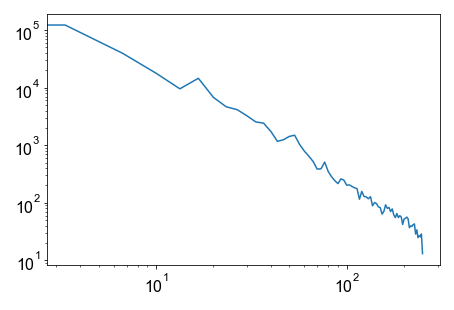

In [18]:
# load sample lfp data
i_session = 1
i_channel = 0

data_in = np.load(f"{EXTERNAL_PATH}/data/lfp/lfp_psd/{SESSIONS[i_session]}_spectra.npz")
print(data_in.files)
freq, all_spectra = data_in['freq'], data_in['spectra_post']
spectra = np.mean(all_spectra[:, i_channel], axis=0) # single channel - trial average
plt.loglog(freq, spectra)


In [20]:
# fooof parameterization
f = SpectralModel(**SPEC_PARAM_SETTINGS)
f.fit(freq, spectra)

In [21]:
offset = f.get_params('aperiodic_params', 'offset')
exp = f.get_params('aperiodic_params', 'exponent')
knee = f.get_params('aperiodic_params', 'knee')
knee_hz = knee_freq(knee, exp)

print(f"Offset: \t{offset:.1f}, \
      \nExponent: \t{exp:.1f}, \
      \nKnee: \t\t{knee:.1f}, \
      \nknee freq: \t{knee_hz:.1f} Hz")

Offset: 	6.7,       
Exponent: 	2.2,       
Knee: 		34.2,       
knee freq: 	5.0 Hz


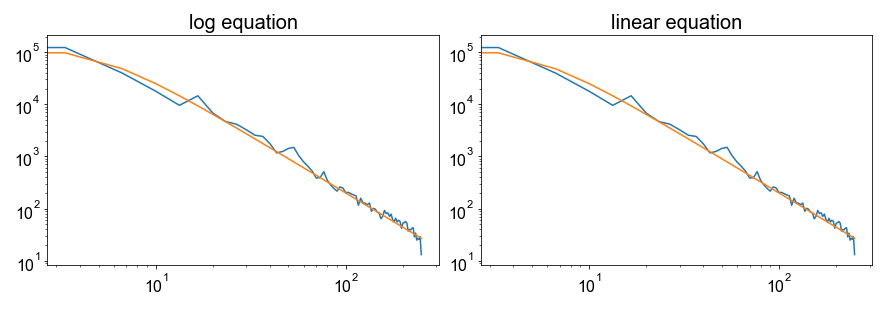

In [22]:
# simulate aperiodic fit - custom

# ap_params = f.get_params('aperiodic_params')
# aperiodic_fit = ap_params[0] - np.log10(ap_params[1] + freq**ap_params[2])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,4])

# log equation
aperiodic_fit = offset - np.log10(knee + freq**exp)
ax1.loglog(freq, spectra)
ax1.loglog(freq, 10**aperiodic_fit)
ax1.set_title("log equation")

# linear equation
aperiodic_fit = 10**offset * (1/(knee + freq**exp))
ax2.loglog(freq, spectra)
ax2.loglog(freq, aperiodic_fit)
ax2.set_title("linear equation")

plt.show()

## Main

In [23]:
# simulate aperiodic fit - specparam

sim_params = {
    'freq_range': [freq[0], freq[-1]],
    'aperiodic_params': f.get_params('aperiodic_params'),
    'periodic_params': [],
    'nlv': 0
}

# sim_freqs, sim_spectra = sim_power_spectrum(**sim_params)
sim_freqs, sim_spectra = sim_power_spectrum(**sim_params)

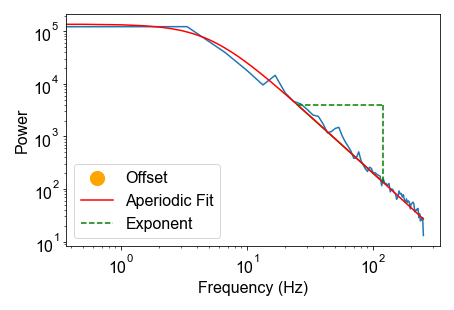

In [24]:
idxs = [50, 240]
x1, y1 = sim_freqs[idxs[0]], sim_spectra[idxs[0]]
x2, y2 = sim_freqs[idxs[1]], sim_spectra[idxs[1]]

# empirical data
plt.loglog(freq, spectra)

# offset
plt.scatter(sim_freqs[0], sim_spectra[0], color='orange', label='Offset',s=200)

# aperiodic fit
plt.loglog(sim_freqs, sim_spectra, label='Aperiodic Fit', color='red')

# exponent
plt.plot((x1, x2),(y1, y1), color='green', linestyle='--', label='Exponent')
plt.plot((x2, x2),(y2, y1), color='green', linestyle='--')
plt.plot((x1, x2),(y1, y2), color='green', linestyle='-', zorder=0)


# stuffs
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.legend();

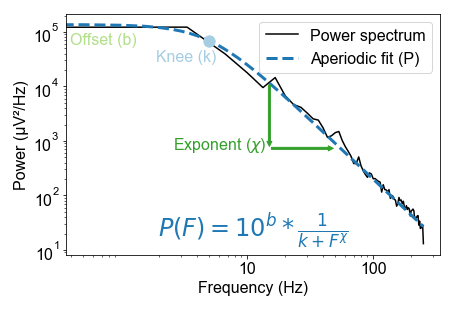

In [31]:
# plot model

# create figure
fig, ax = plt.subplots()

# empirical data
ax.loglog(freq, spectra, color='k', label="Power spectrum", zorder=0)

# aperiodic fit
ax.loglog(sim_freqs, sim_spectra, color=colors[0], linestyle='--', linewidth=3,
          label='Aperiodic fit (P)', zorder=1)

# offset
ax.scatter(sim_freqs[0], sim_spectra[0], color=colors[1], s=128, zorder=2)

# knee 
idx_knee = np.argmin(np.abs(sim_freqs-knee_hz))
ax.scatter(sim_freqs[idx_knee], sim_spectra[idx_knee], color=colors[2], s=128, zorder=2)

# exponent 
idxs = [30, 110]
x1, y1 = sim_freqs[idxs[0]], sim_spectra[idxs[0]]
x2, y2 = sim_freqs[idxs[1]], sim_spectra[idxs[1]]
ax.add_patch(mpatches.FancyArrowPatch((x1, y1), (x1, y2), mutation_scale=10, color=colors[3]))
# ax.add_patch(mpatches.FancyArrowPatch((x1, y2), (x2, y2), mutation_scale=16, color=colors[1]))
ax.add_patch(mpatches.FancyArrowPatch((x1, y2), (50, y2), mutation_scale=10, color=colors[3]))

# labels
ax.set_xticks([10, 100], labels=['10', '100'])
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (\u03BCV\u00b2/Hz)') 
ax.legend()

# aperiodic annotation
ax.text(0.10, 0.89, 'Offset (b)', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color=colors[1])
ax.text(0.32, 0.82, 'Knee (k)', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color=colors[2])
ax.text(0.41, 0.46, 'Exponent ($\chi$)', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color=colors[3])

# equation 
# ax.text(0.5, 0.1, 'L = b - log(k + $F^\chi$)', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color=colors[0], fontsize=24)
ax.text(0.5, 0.1, r'$P(F) = 10^b * \frac{1}{k+F^\chi}$', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, color=colors[0], fontsize=24)

plt.savefig(f'{dir_out}/methods_specparam.png')

plt.show()